<div id="title"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:50px;text-align:center">U-Net Multiclasses Training</h1></div>

Projeto desenvolvido usando a rede de segmentação U-NET, biblioteca Keras e Tensorflow.
O Road Mapper DNN tem como objetivo gerar mapas de estrada com segmentação das faixas de sinalização utilizada pelos veículos, tendo como entrada mapas de remissão gerados pelo LIDAR - sensor laser que faz parte do sistema de carros autônomos como o ASTRO da Lume Robotics.


Input | Output
------|--------
![](https://github.com/LCAD-UFES/carmen_lcad/blob/master/src/road_mapper/data/i7705600_-338380.png?raw=true)|![](https://github.com/LCAD-UFES/carmen_lcad/blob/master/src/road_mapper/data/r7705600_-338380_map_1_6.png?raw=true)



## <div id="summary">**<font color="#62909d" size="5">Tabela de Conteúdos</font>**</div>

**<font size="2"><a href="#chap1">1. Instalar Pacotes</a></font>**
**<br><font size="2"><a href="#chap2">2. Configurações Iniciais</a></font>**
**<br><font size="2"><a href="#chap3">3. Tratamento de Dados</a></font>**
**<br><font size="2"><a href="#chap4">4. Compilação e Treinamento da Rede</a></font>**
**<br><font size="2"><a href="#chap5">5. Analisando os Resultados</a></font>**
**<br><font size="2"><a href="#chap6">6. Realizando Testes</a></font>**

<div id="chap1"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:50px;text-align:center">Instalar Pacotes</h1></div>


In [ ]:
%pip install opencv-python
%pip install tensorflow
%pip install numpy
%pip install tqdm
%pip install scikit-image
%pip install scikit-learn
%pip install matplotlib


In [ ]:
%pip install kaggle

<div id="chap2"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:30px;text-align:center">Configurações Iniciais</h1></div>


In [1]:
# Importando as principais bibliotecas

import os
import glob

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow as tf




In [2]:
# Conexão com o drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# rode essa célula apenas para criar uma pasta no root

!kaggle datasets download -d ludmiladias/road-mapper-dataset-csv


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
# verificando se a pasta foi criada
!find . -iname ".kaggle"

In [ ]:
!ls

drive  sample_data


In [ ]:
# move o arquivo kaggle.json importado
!cp /content/drive/MyDrive/ROAD_MAPPER_DNN/kaggle.json ../root/.kaggle/kaggle.json

In [ ]:
# Importar dataset do Kaggle

!kaggle datasets download -d ludmiladias/road-mapper-dataset-csv
!unzip road-mapper-dataset-csv.zip

100% 1.65G/1.65G [00:25<00:00, 80.1MB/s]
100% 1.65G/1.65G [00:25<00:00, 69.2MB/s]
Archive:  road-mapper-dataset-csv.zip
  inflating: test_cleaned.csv        
  inflating: teste_all_classes.csv   
  inflating: train_cleaned.csv       


In [ ]:
# Definição de variaveis iniciais

SIZE_X = 128
SIZE_Y = 128

TRAIN_PATH = 'DATASET/treino/'
TEST_PATH_HIGHWAY = 'DATASET/teste/highway/'
TEST_PATH_UFES = 'DATASET/teste/ufes/'

IMG_CHANNELS = 1
NUM_CLASSES = 17  # Número de classes

<div id="chap3"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:50px;text-align:center">Tratamento de Dados</h1></div>

Pule essa etapa se você já tiver seus dados prontos em um CSV.

**<font color="#62909d" size="5">Importando os arquivos</font>**


In [ ]:
# Obter uma lista das subpastas
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids_hw = next(os.walk(TEST_PATH_HIGHWAY))[1]
test_ids_uf = next(os.walk(TEST_PATH_UFES))[1]

In [ ]:
X_train = np.zeros((len(train_ids), SIZE_Y, SIZE_X, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), SIZE_Y, SIZE_X), dtype = np.uint8)


X_test = np.zeros((len(test_ids_hw), SIZE_Y, SIZE_X, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids_hw), SIZE_Y, SIZE_X), dtype = np.uint8)


In [ ]:
# CARREGA IMAGENS PARA ARRAY DE TREINO
def imgs_to_array(TRAIN_PATH, type_data):
    if type_data == 'I':

        for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):

            path = TRAIN_PATH + id_

            # Read the image and keep the first IMG_CHANNELS channels
            img = imread(path + '/images/i' + id_ + '.png', 0)

            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            img = np.expand_dims(img, axis=2)

            # Resize the image to SIZE_Y x SIZE_X while keeping the pixel values (mode='constant')
            img = resize(img, (SIZE_Y, SIZE_X), mode='constant', preserve_range=True)

            # Store the processed image into the X_train array at index n
            X_train[n]=img

        return X_train

    elif type_data == 'M':
    # Loop through all train_ids
        for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):

            path = TRAIN_PATH + id_

            # Read the mask file
            mask = imread(path + '/masks/r' + id_ + '.png', 0)

            mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)


            # Store the processed mask into the Y_train array at index n
            Y_train[n] = mask

        return Y_train

    return []

In [ ]:
image_dataset = imgs_to_array(TRAIN_PATH, type_data='I') # 'I' - Imagens de input
mask_dataset = imgs_to_array(TRAIN_PATH, type_data='M') # 'M' - Masks do Ground Truth

In [ ]:
# SALVAR ARRAYS DAS IMAGENS

import pickle
try:
    arquivo = open("bin/image_dataset.bin", "wb")
    pickle.dump(image_dataset, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treino.")

try:
    arquivo = open("bin/mask_dataset.bin", "wb")
    pickle.dump(mask_dataset, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo teste.")

In [ ]:
#  LOAD DOS ARRAYS SALVOS

import pickle

try:
    arquivo = open("/kaggle/input/road-mapper-dataset/image_dataset.bin", "rb")
    image_dataset = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")

try:
    arquivo = open("/kaggle/input/road-mapper-dataset/mask_dataset.bin", "rb")
    mask_dataset = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinoy.")

In [ ]:
#  LOAD DOS ARRAYS SALVOS

import pickle

try:
    arquivo = open("/content/x_train_50k.bin", "rb")
    X_train = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")

try:
    arquivo = open("/content/y_train_50k.bin", "rb")
    y_train = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinoy.")

**<font color="#62909d" size="5">Normalização e tratamento dos arrays</font>**


In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

In [ ]:
# Normalizar dados do X
image_dataset = normalize(image_dataset, axis=1)

In [ ]:
# Realizar o Label Encoder
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = image_dataset.shape
train_masks_reshaped = image_dataset.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

In [ ]:
#Dividir dados de treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, train_masks_input, test_size = 0.2, random_state = 42)

In [ ]:
print("Os valores das classes nesse dataset são ... ", np.unique(y_train))

In [ ]:
# Gerar pesos das classes (nova implementação em processo)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(train_masks_reshaped_encoded),
                                                 y = train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

**<font color="#62909d" size="5">Salvar arquivo como CSV</font>**


In [ ]:
import csv
import pandas as pd

def salvar_csv(X, Y, file_name):
    # Criar um DataFrame com os arrays
    data = {'X_input': X.tolist(), 'Y_output': Y.tolist()}
    df = pd.DataFrame(data)
    df.to_csv(file_name, index=False, mode="a")

In [ ]:
# Para salvar arquivo grande em partes
for i in range(0,1):
    print(i)
    salvar_csv(X_train[(i*100):((i+1)*100)], y_train[(i*100):((i+1)*100)], 'train_data50.csv') # arquivo de treino

0


In [ ]:
for j in range(0,2):
    print(j)
    salvar_csv(X_test[(j*5000):((j+1)*5000)], Y_test[(j*5000):((j+1)*5000)], 'test_data50.csv') # arquivo de teste

In [ ]:
# Link para download dos arquivos
from IPython.display import FileLink, FileLinks
display(FileLink('train_data.csv'))
display(FileLink('test_data.csv'))


<div id="chap4"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:40px;text-align:center">Compilação e Treinamento da Rede</h1></div>

**<font color="#62909d" size="5">Modelo 1 - Original U-NET</font>**

In [ ]:
# Criando uma função para um convolution block
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu",
                               kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu",
                               kernel_initializer="he_normal", padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    return x

# Criando a função para o expanding path
def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv


In [ ]:
import tensorflow as tf

# Inputs
inputs = tf.keras.layers.Input((SIZE_X, SIZE_Y, IMG_CHANNELS))

# Normalização
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs)

# Contraction path
c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

# Expansive path
c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)

# Output layer

outputs = tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(c9)

In [ ]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name="U-Net")
# Compilação
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.save('multiclass_road_mapper')
model.summary()


**<font color="#62909d" size="5">Modelo 2 - Custom U-NET</font>**
<br>**Modelo sendo utilizado no momento**

In [ ]:
!pip install keras_unet

In [ ]:
from keras_unet.models import custom_unet

def get_customunet():
  model = custom_unet(
      input_shape=(128, 128, 1),
      use_batch_norm=True,
      num_classes=17,
      filters=16,
      dropout=0.2,
      output_activation='softmax')
  print(model.summary())
  return model

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------



**<font color="#62909d" size="5">Compilando o Modelo</font>**

In [ ]:

# Carregando o modelo
from keras.models import load_model

def load_new_model():
    model = load_model('/content/drive/MyDrive/Lume/road_mapper_dnn/new_train_road_mapper_0611')
    model.load_weights('/content/drive/MyDrive/Lume/road_mapper_dnn/new_train_road_mapper_0611')
    nome_salvar_modelo = '/content/drive/MyDrive/ROAD_MAPPER_DNN/TREINOS/new_train_road_mapper_0611_2.keras'

    #optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3)
    # loss = tf.keras.losses.SparseCategoricalCrossentropy()

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['MeanIoU', 'Recall', 'Precision'])
    model.save(nome_salvar_modelo)

    return model

In [ ]:
# Compilar e Salvar modelo
def get_model():
  model=get_customunet()

  nome_salvar_modelo = '/content/drive/MyDrive/ROAD_MAPPER_DNN/TREINOS/new_train_road_mapper_0611.keras'

  opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  model.save(nome_salvar_modelo)
  return model

In [ ]:
# # Compilar e Salvar modelo
# nome_salvar_modelo = '/content/drive/MyDrive/Lume/road_mapper_dnn/multiclass_road_mapper_customunet_10'

# opt = tf.keras.optimizers.Adam(learning_rate=0.0015)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.save(nome_salvar_modelo)

**<font color="#62909d" size="5">Batch Generator</font>**

In [ ]:
import requests
import time

def avoid_inactivity():
    try:
        requests.get('https://www.google.com')
        return False
    except:
        return True

In [ ]:
from tensorflow.keras.utils import to_categorical
import json
from keras.utils import normalize

import pandas as pd

def batch_generator(Train_df,batch_size,
                    steps, skiprows):
    idx=1
    while True:
        yield load_data(Train_df,idx-1,batch_size, skiprows[idx-1])## Yields data
        if idx<steps:
            idx+=1
        else:
            idx=1
        avoid_inactivity()

def load_data(Train_df,idx,
              batch_size, sr):
    n_classes = 17

    df = pd.read_csv(
                  Train_df, skiprows=sr,
                  nrows=batch_size)

    x = []
    y = []

    for i in range(0, batch_size):
        x.append(json.loads(df.iloc[i,0]))
        y.append(json.loads(df.iloc[i,1]))

    y = np.asarray(y)
    x = np.asarray(x)

    train_masks_cat = to_categorical(y, num_classes=n_classes)
    y = train_masks_cat.reshape((y.shape[0], y.shape[1], y.shape[2], n_classes))
    x = normalize(x, axis=1)


    return (x, y)

In [ ]:
def getsteps(total_dados, batch_size):
  print((total_dados//batch_size)*batch_size)
  return total_dados//batch_size

In [ ]:
import numpy as np
import random

from keras.models import Sequential
from keras.layers import Dense, Activation
quant_train = 39424
quant_test = 9984
batch_size = 256
nb_epoch = 5
skiprows = []

# Objetos gerados para treino e validação
steps_per_epoch=np.ceil(getsteps(quant_train,batch_size))
validation_steps=np.ceil(getsteps(quant_test,batch_size))

total_dados = quant_test + quant_train
for sr in range(0, total_dados, batch_size):
  skiprows.append(sr)

random.shuffle(skiprows)

my_training_batch_generator = batch_generator('/content/train_cleaned.csv', batch_size,steps_per_epoch, skiprows[0:int(steps_per_epoch)])##
my_validation_batch_generator = batch_generator('/content/train_cleaned.csv', batch_size,validation_steps, skiprows[int(steps_per_epoch):])##

39424
9984


**<font color="#62909d" size="5">Treinamento</font>**

In [ ]:
# Model Checkpoint e Early Stopping
# https://github.com/luddias/DeepLearning-About/blob/main/checkpointing.md
# https://github.com/luddias/DeepLearning-About/blob/main/early_stoping.md

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="/content/drive/MyDrive/Lume/road_mapper_dnn/new_train_road_mapper_0611_2"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='categorical_accuracy', patience=2)
callbacks_list = [checkpoint, es]



In [ ]:
import os
import json

import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # multi_worker_model= get_model()
    multi_worker_model= load_new_model()

In [ ]:
# Treinamento
import tensorflow as tf
import pandas as pd

with strategy.scope():
    history= multi_worker_model.fit(my_training_batch_generator,
                    epochs=nb_epoch,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    validation_data=my_validation_batch_generator,
                    validation_steps=validation_steps,
                    callbacks=[callbacks_list])

Epoch 1/5
154/154 [==============================] - ETA: 0s - loss: 0.8263 - categorical_accuracy: 0.7425 
Epoch 1: val_categorical_accuracy improved from -inf to 0.71306, saving model to /content/drive/MyDrive/Lume/road_mapper_dnn/new_train_road_mapper_0611_2
154/154 [==============================] - 3951s 26s/step - loss: 0.8263 - categorical_accuracy: 0.7425 - val_loss: 1.2057 - val_categorical_accuracy: 0.7131
Epoch 2/5
154/154 [==============================] - ETA: 0s - loss: 0.6797 - categorical_accuracy: 0.7659 
Epoch 2: val_categorical_accuracy improved from 0.71306 to 0.75391, saving model to /content/drive/MyDrive/Lume/road_mapper_dnn/new_train_road_mapper_0611_2
154/154 [==============================] - 3902s 25s/step - loss: 0.6797 - categorical_accuracy: 0.7659 - val_loss: 0.7442 - val_categorical_accuracy: 0.7539
Epoch 3/5
154/154 [==============================] - ETA: 0s - loss: 0.6016 - categorical_accuracy: 0.7813 
Epoch 3: val_categorical_accuracy improved from 0

In [ ]:
# Salvando o mode
model.save('multiclass_road_mapper_custom_0012_2_10.keras')


In [ ]:
training_metrics = {
    "loss": [0.8263, 0.6797, 0.6016, 0.5486, 0.5061],
    "categorical_accuracy": [0.7425, 0.7659, 0.7813, 0.7933, 0.8040],
    "val_loss": [1.2057, 0.7442, 0.5669, 0.5078, 0.4775],
    "val_categorical_accuracy": [0.7131, 0.7539, 0.7863, 0.8035, 0.8106]
}


In [ ]:
from __future__ import print_function

import pandas as pd
pd.__version__

'1.5.3'

In [ ]:

dict = {'Training Loss': history['loss'], 'Val Loss': history['val_loss'],
        'Training Acc': history['categorical_accuracy'], 'Val Acc': history['val_categorical_accuracy']}
df = pd.DataFrame(dict)
df

,Training Loss,Val Loss,Training Acc,Val Acc
0,0.6459,0.7103,0.7724,0.7615
1,0.6071,0.5944,0.7800,0.7830
2,0.5550,0.5609,0.7864,0.7908
3,0.5550,0.5361,0.7919,0.7974
4,0.5437,0.5361,0.7945,0.7974
5,0.5391,0.5296,0.7954,0.7981
6,0.5194,0.5103,0.8002,0.8034
7,0.5045,0.5060,0.8066,0.8030
8,0.4930,0.4932,0.8093,0.8068
9,0.4820,0.4794,0.8097,0.8122


In [ ]:
# Salvando os resultados
import pickle
try:
    arquivo = open("/content/drive/MyDrive/Lume/road_mapper_dnn/results_10K_32_10_0012.json", "wb")
    pickle.dump(history, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo results.")


In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [ ]:
download_file('/kaggle/working', 'out')

# Treinamento com Validação Cruzada

In [ ]:
import pickle
def get_folds(skiprows, n_folds):
  idx_por_fold = len(skiprows)/n_folds
  sk_fold = []

  for idx in range(0, n_folds):
    sk_fold.append(list(skiprows[idx*idx_por_fold:(idx+1)*idx_por_fold]))

  return sk_fold

def save_file_txt(name, data):

  try:
    with open('name', 'w') as arquivo:
        # Adiciona mais conteúdo ao arquivo
          arquivo.write(str(data))
  except:
      print("Problemas ao salvar arquivo.")


In [ ]:
import numpy as np
import random

from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import KFold
quant_train = 38912
quant_test = 9728
batch_size = 256
nb_epoch = 1
skiprows = []
results = []
metrics = []

# Objetos gerados para treino e validação
steps_per_epoch=np.ceil(getsteps(quant_train,batch_size))
validation_steps=np.ceil(getsteps(quant_test,batch_size))

total_dados = quant_test + quant_train
for sr in range(0, total_dados, batch_size):
  skiprows.append(sr)

random.shuffle(skiprows)

sk_fold = get_folds(skiprows, 5)

for i in range(2,5):
  train_data = sk_fold[i]
  val_data = []

  for j in range(5):
    if j!=i:
      val_data.extend(sk_fold[j])

  my_training_data_generator = data_generator('/content/train_cleaned.csv', batch_size,steps_per_epoch, train_data)##
  my_validation_data_generator = data_generator('/content/train_cleaned.csv', batch_size,validation_steps, val_data)##

  strategy = tf.distribute.MirroredStrategy()

  with strategy.scope():
      multi_worker_model= get_model()

      history= multi_worker_model.fit(my_training_batch_generator,
                    epochs=nb_epoch,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    validation_data=my_validation_batch_generator,
                    validation_steps=validation_steps,
                    callbacks=[callbacks_list])
  results.append(history)
  multi_worker_model.save('/content/drive/MyDrive/ROAD_MAPPER_DNN/kfold_model'+str(i)+'.keras')


save_file_txt('/content/drive/MyDrive/ROAD_MAPPER_DNN/kfold_results.txt', results)


38912
9728
38
152
152/152 [==============================] - ETA: 0s - loss: 0.4910 - categorical_accuracy: 0.8077 
Epoch 1: val_categorical_accuracy improved from -inf to 0.82125, saving model to /content/drive/MyDrive/Lume/road_mapper_dnn/kfold_model_0711_2
152/152 [==============================] - 7419s 49s/step - loss: 0.4910 - categorical_accuracy: 0.8077 - val_loss: 0.4443 - val_categorical_accuracy: 0.8213
38
152
152/152 [==============================] - ETA: 0s - loss: 0.4936 - categorical_accuracy: 0.8072 
Epoch 1: val_categorical_accuracy improved from -inf to 0.82143, saving model to /content/drive/MyDrive/Lume/road_mapper_dnn/kfold_model_0711_3
152/152 [==============================] - 7184s 47s/step - loss: 0.4936 - categorical_accuracy: 0.8072 - val_loss: 0.4413 - val_categorical_accuracy: 0.8214
38
152
152/152 [==============================] - ETA: 0s - loss: 0.4952 - categorical_accuracy: 0.8066 
Epoch 1: val_categorical_accuracy improved from -inf to 0.82546, savin

<div id="chap5"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:40px;text-align:center">Avaliando parâmetros com GridSearch</h1></div>

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
import os
import json

import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    unet= get_model()

In [ ]:
parameters = {'learning_rate': [0.0001,0.0002,0.0003],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,200,500],
                  'max_depth'    : [4,6,8]
            }

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'MSE': 'neg_mean_squared_error',
    'log_loss': 'neg_log_loss',
    'AUC-ROC': 'roc_auc',
    'MAE': 'neg_mean_absolute_error',
}

In [ ]:
grid_unet = GridSearchCV(estimator=unet, param_grid = parameters, cv = 5, n_jobs=-1, scoring = scoring, refit="accuracy")

xy_generator = list(my_training_batch_generator)

with strategy.scope():
  grid_unet.fit(xy_generator)

TypeError: ignored

<div id="chap5"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:40px;text-align:center">Analisando os Resultados</h1></div>

In [ ]:
# Importando arquivo de resultados
import pickle

try:
    arquivo = open("/kaggle/working/results.bin", "rb")
    history = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")

Problemas com o arquivo treinox.


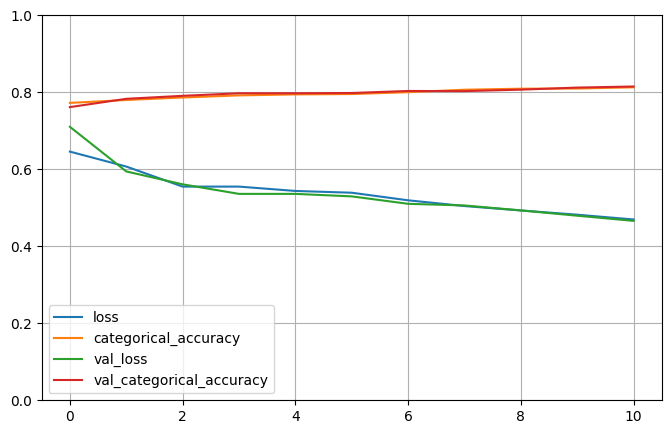

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

pd.DataFrame(history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig("/content/drive/MyDrive/Lume/road_mapper_dnn/src/results_10k_32_10_0015_curvegraph.png",format='png')
plt.show()

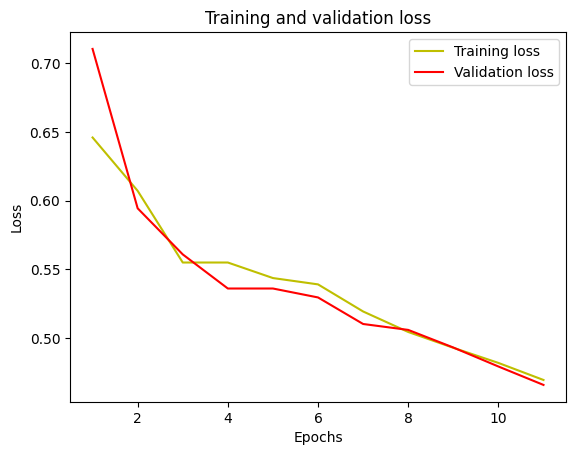

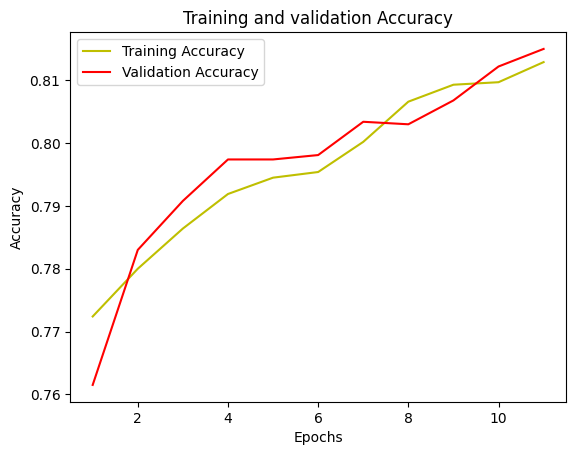

In [ ]:
from matplotlib import pyplot as plt

loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Lume/road_mapper_dnn/src/results_10k_32_10_0015_loss.png', format='png')
plt.show()

acc = history['categorical_accuracy']
val_acc = history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/Lume/road_mapper_dnn/src/results_10k_32_10_0015_acc.png', format='png')
plt.show()

In [ ]:
# Load do modelo salvo
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Lume/road_mapper_dnn/kfold_model_0711_4", compile=False)
fold = 5

<div id="chap6"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:40px;text-align:center">Realizando testes (Predict)</h1></div>

## **Importando Bibliotecas**

In [ ]:
import datetime
from tensorflow.keras.utils import to_categorical
import numpy as np

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.metrics import mean_squared_error, balanced_accuracy_score, precision_score, recall_score, f1_score, jaccard_score

## **Importando e Tratando dados**

In [ ]:
from sklearn.preprocessing import LabelEncoder
def labelencoder(train_masks):
    labelencoder = LabelEncoder()
    n, h, w = train_masks.shape[:3]
    train_masks_reshaped = train_masks.reshape(-1,1)
    train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

#     print("encoder concluido")
#     return np.expand_dims(train_masks_encoded_original_shape, axis=3)
    return train_masks_encoded_original_shape

In [ ]:
def tocat(y, n_classes):
    train_masks_cat = to_categorical(y, num_classes=n_classes)
    return train_masks_cat.reshape((y.shape[0], y.shape[1], y.shape[2], n_classes))

In [ ]:
# Importando dados de teste
import pickle

try:
    arquivo = open("/kaggle/input/test-dataset/test_imgs.bin", "rb")
    X_test = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")

try:
    arquivo = open("/kaggle/input/test-dataset/test_masks_NE.bin", "rb")
    Y_test = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")

Y_test = tocat(Y_test[:1280], 17)

In [ ]:
import json
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from keras.utils import normalize


def test_data_generator(pos_ini, mode):
  test_df = "teste_all_classes.csv"

  df = pd.read_csv(
                    test_df, skiprows=pos_ini, nrows=1)
  n_classes=17
  x = []
  y = []
  for i in range(0, len(df)):
      x.append(json.loads(df.iloc[i,0]))
      y.append(json.loads(df.iloc[i,1]))

  if mode=='x':
    x = normalize(x, axis=1)
    return np.asarray(x)
  elif mode=='y':
    return np.asarray(y)

  return None

In [ ]:
# x_test = test_data_generator(0, 'x')
# y_test = test_data_generator(0, )

## **Acurácia e F1 Score**

- **Acurácia (Accuracy)**:
   - A acurácia é uma métrica de avaliação comum em problemas de classificação.
   - Ela mede a proporção de previsões corretas feitas pelo modelo em relação ao número total de previsões.
   - A fórmula para a acurácia é: $$ \text{Acurácia} = \frac{\text{Verdadeiros Positivos} + \text{Verdadeiros Negativos}}{\text{Verdadeiros Positivos} + \text{Falsos Positivos} + \text{Verdadeiros Negativos} + \text{Falsos Negativos}} $$.
   - A acurácia é simples de entender, mas pode ser enganosa em conjuntos de dados desequilibrados, onde uma classe é muito mais comum do que outras, pois o modelo pode atingir uma alta acurácia simplesmente prevendo a classe majoritária.


        
- **F1-Score**:
   - O F1-Score é uma métrica que leva em consideração tanto a precisão quanto o recall (revocação) e é útil em problemas de classificação desequilibrados.
   - O F1-Score é a média harmônica da precisão e do recall e é calculado pela fórmula: $$ F1 = \frac{2 \times \text{Precisão} \times \text{Revocação}}{\text{Precisão} + \text{Revocação}} $$.
   - A precisão mede a proporção de previsões positivas corretas, enquanto o recall mede a capacidade do modelo de identificar todos os casos positivos.
   - O F1-Score é especialmente útil quando você deseja encontrar um equilíbrio entre a precisão e o recall, pois leva em consideração tanto os falsos positivos quanto os falsos negativos.

Em resumo, a acurácia mede a proporção de previsões corretas, enquanto o F1-Score é uma métrica que combina precisão e recall, útil em problemas de classificação desequilibrados. A escolha entre essas métricas depende do contexto e dos objetivos específicos de avaliação do seu modelo de aprendizado de máquina.

In [ ]:
accuracy_list = []
f1_list = []

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
from scipy.special import softmax

n_classes=17
num_imgs = int(2000//4)
# num_imgs = 10
batch_size = 1
all_predict = []
all_gt = []
all_prob = []
accuracy_list = []
f1_list = []


for i in tqdm(range(0, num_imgs), desc="Processing.."):

    # Gera os dados
    y_pred = model.predict(test_data_generator(i, 'x'), verbose=0)
    Y_test = test_data_generator(i, 'y')
    # print(test_data_generator(i, 'y'))

    # Retorna o indice de maior valor (o que refere-se ao numero da classe)
    y_pred_argmax=np.argmax(y_pred, axis=3)

    # # Salvar probabilidades
    # class_probabilities = tf.nn.softmax(y_pred, axis=-1).numpy()

    # Transforma todos os valores para inteiro
    Y_test= Y_test.astype(np.uint8)
    y_pred= y_pred_argmax.astype(np.uint8)

    # Transforma o array 3D em um array 1D
    predictions_flat = y_pred.flatten()
    y_flat = Y_test.flatten()

    # all_prob.extend(class_probabilities)
    all_predict.extend(predictions_flat)
    all_gt.extend(y_flat)

    # Calcula e salva o score
    accuracy_list.append(accuracy_score(y_flat, predictions_flat))

    f1 = f1_score(y_flat, predictions_flat, average='macro')
    f1_list.append(f1)

print('Finished!')

len(accuracy_list)

Processing..: 100%|██████████| 500/500 [04:06<00:00,  2.03it/s]

Finished!


500

In [ ]:
medias_evaluation = {"Accuracy": [sum(accuracy_list)/len(accuracy_list)], "F1": [sum(f1_list)/len(f1_list)]}
pd.DataFrame(medias_evaluation, index=["KFOLD "+str(fold)])

,Accuracy,F1
KFOLD 5,0.781531,0.3601


In [ ]:
import pickle
try:
  with open('/content/drive/MyDrive/ROAD_MAPPER_DNN/metrics_0611.txt', 'w') as arquivo:
      # Adiciona mais conteúdo ao arquivo
        arquivo.write(str(medias_evaluation))
except:
    print("Problemas com o arquivo treino.")


## **Matriz de Confusão**
Uma matriz de confusão (confusion matrix) é uma tabela que é usada em problemas de classificação para avaliar o desempenho de um modelo de aprendizado de máquina. Ela é frequentemente usada para resumir o desempenho de um algoritmo de classificação em relação a um conjunto de dados de teste no qual os rótulos verdadeiros são conhecidos.

Uma matriz de confusão tem as seguintes quatro entradas principais:

**Verdadeiro Positivo (True Positive - TP):** Representa os casos em que o modelo classificou corretamente uma instância como positiva (classe de interesse) quando ela realmente era positiva.

**Falso Positivo (False Positive - FP):** Representa os casos em que o modelo classificou erroneamente uma instância como positiva quando na verdade era negativa (uma espécie de erro do tipo I).

**Verdadeiro Negativo (True Negative - TN):** Representa os casos em que o modelo classificou corretamente uma instância como negativa quando ela realmente era negativa.

**Falso Negativo (False Negative - FN):** Representa os casos em que o modelo classificou erroneamente uma instância como negativa quando na verdade era positiva (uma espécie de erro do tipo II).

O desempenho de um modelo de classificação pode ser avaliado examinando os valores na matriz de confusão, permitindo que você entenda como o modelo está classificando as instâncias em diferentes categorias e identifique possíveis áreas de melhoria no modelo.

In [ ]:
from sklearn.metrics import confusion_matrix
cm_geral = confusion_matrix(all_gt, all_predict)


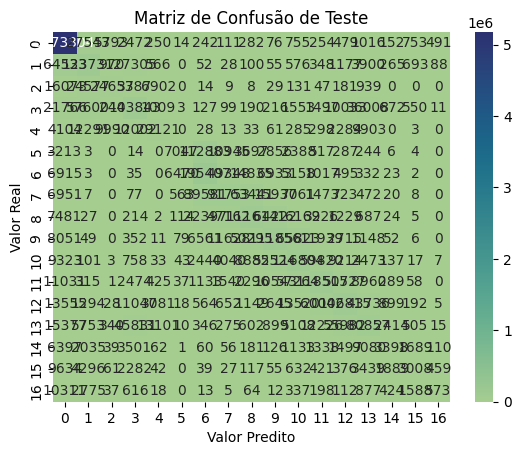

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm_geral, annot=True, fmt='d', cmap='crest')
plt.title('Matriz de Confusão de Teste')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real')
plt.savefig('kfold'+str(fold)+'_0711_mc.png', format='png')
plt.show()


accuracy_custom para a classe 0 :0.6315068359375


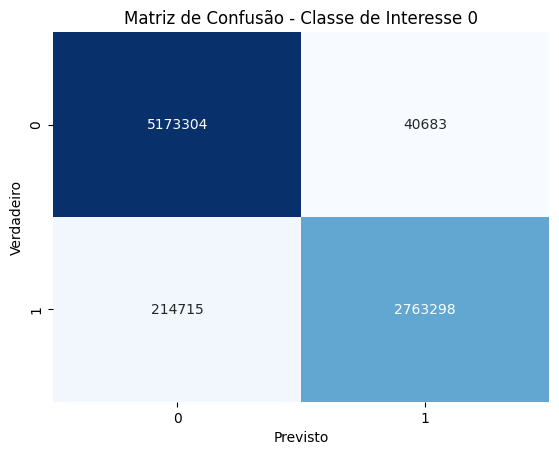

accuracy_custom para a classe 1 :0.0151038818359375


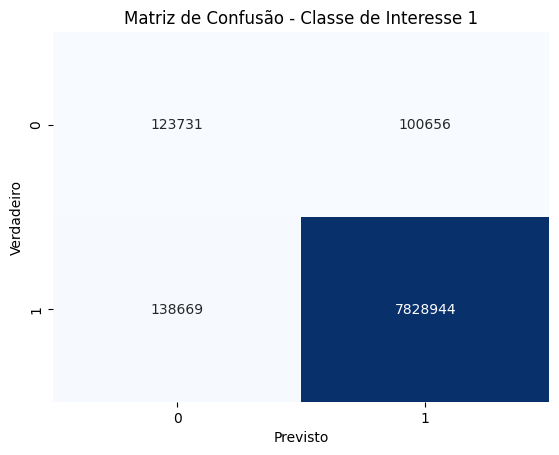

accuracy_custom para a classe 2 :0.0030098876953125


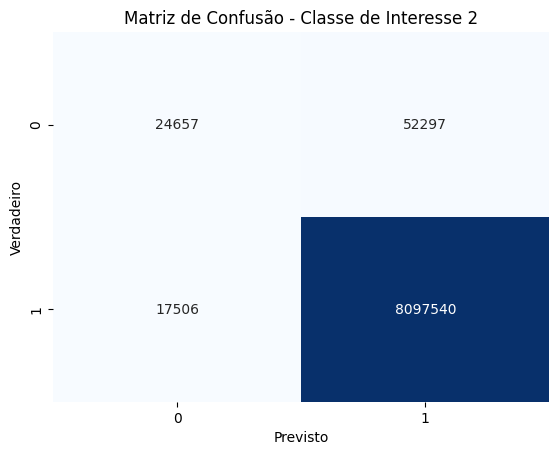

accuracy_custom para a classe 3 :0.0126761474609375


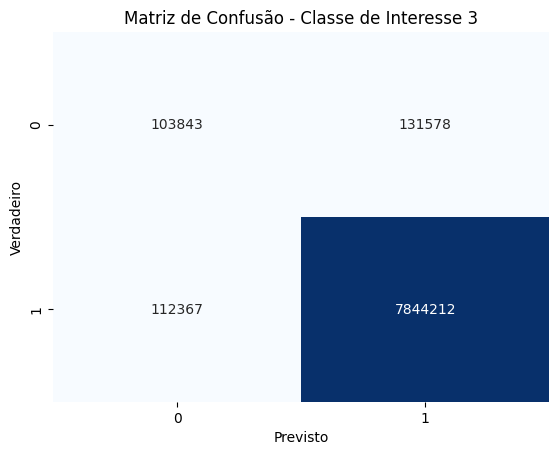

accuracy_custom para a classe 4 :0.0035548095703125


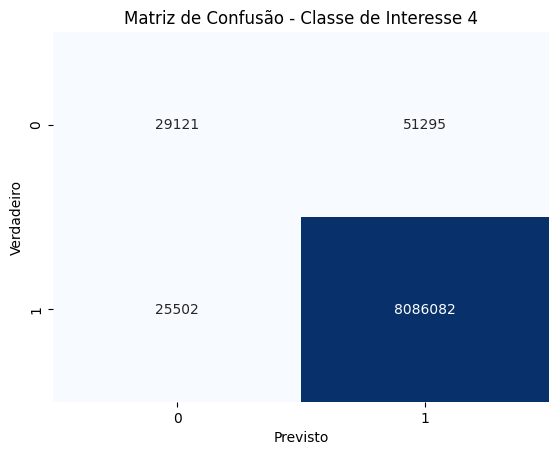

accuracy_custom para a classe 5 :0.0008602294921875


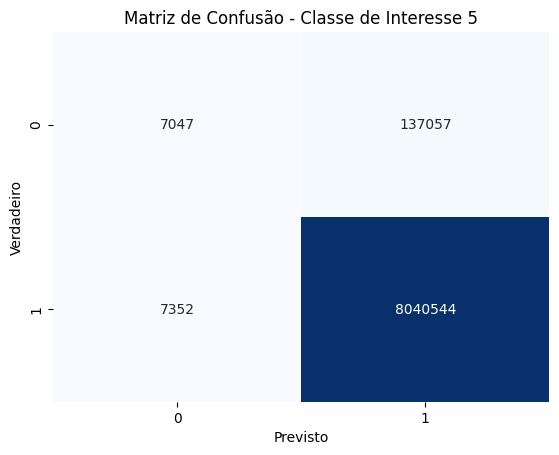

accuracy_custom para a classe 6 :0.0238533935546875


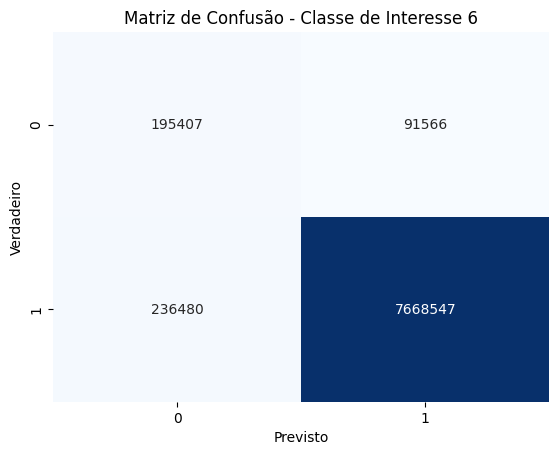

accuracy_custom para a classe 7 :0.0112003173828125


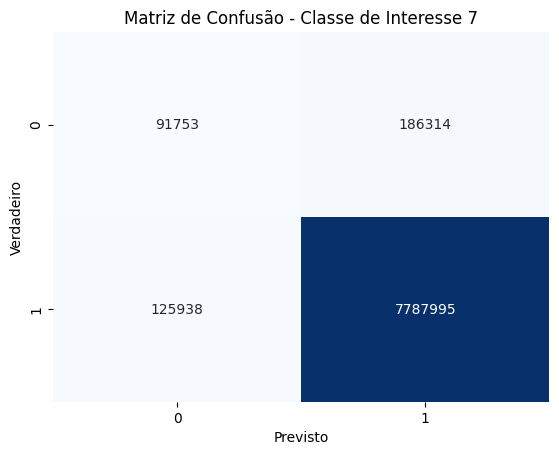

accuracy_custom para a classe 8 :0.013624755859375


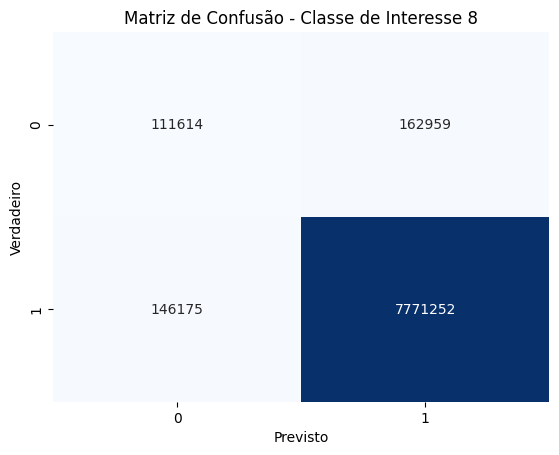

accuracy_custom para a classe 9 :0.013654296875


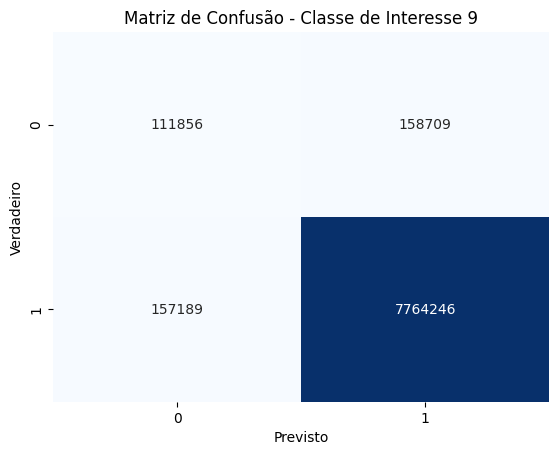

accuracy_custom para a classe 10 :0.01425830078125


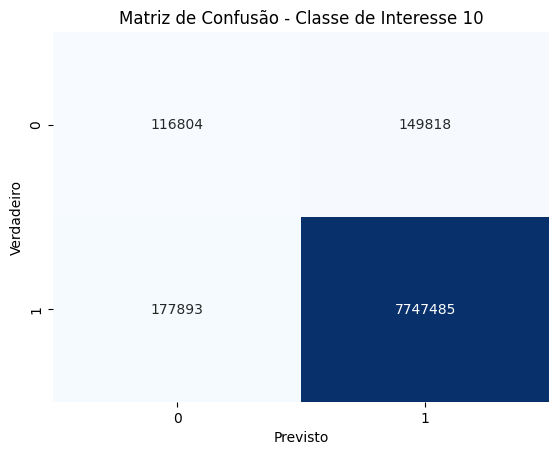

accuracy_custom para a classe 11 :0.0144671630859375


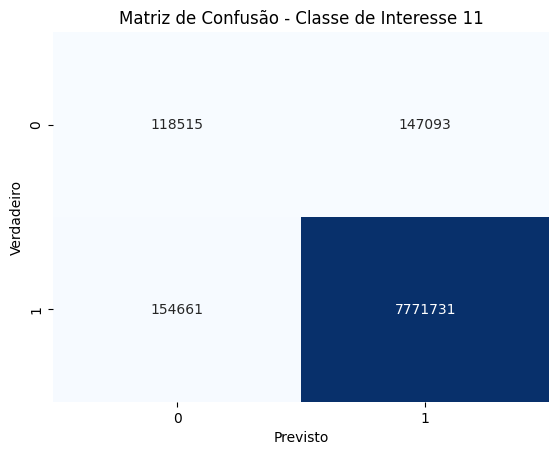

accuracy_custom para a classe 12 :0.0130389404296875


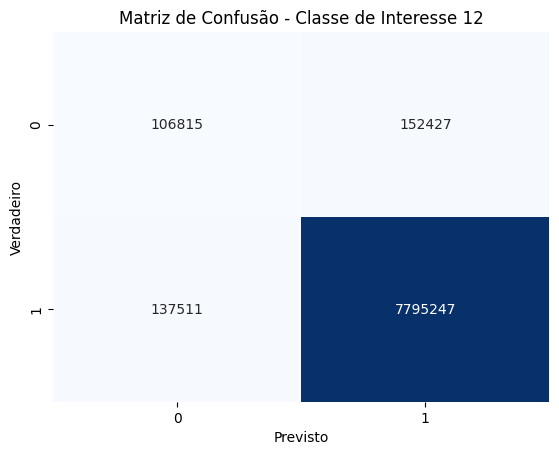

accuracy_custom para a classe 13 :0.0098702392578125


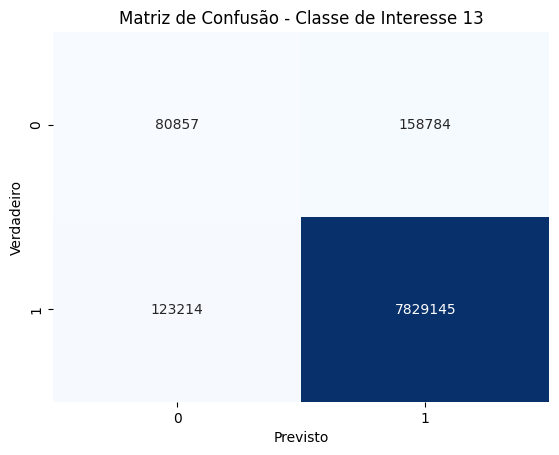

accuracy_custom para a classe 14 :0.000414794921875


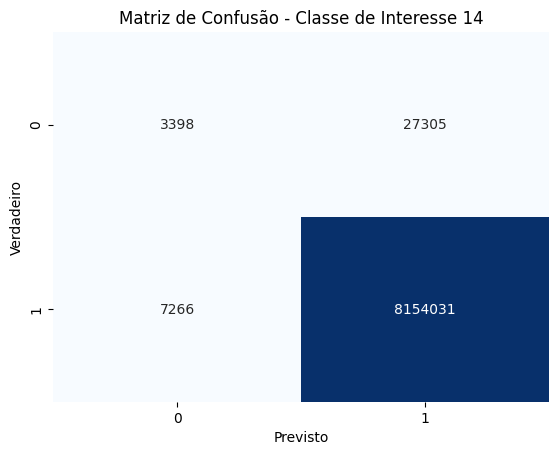

accuracy_custom para a classe 15 :0.0003671875


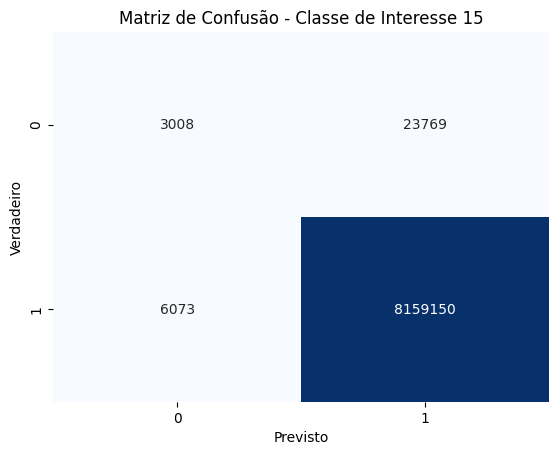

accuracy_custom para a classe 16 :6.99462890625e-05


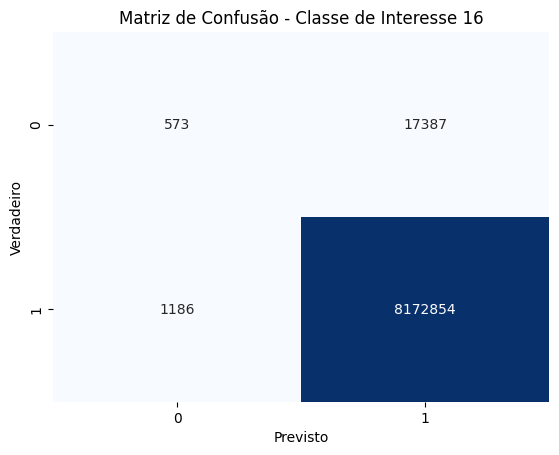

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# y_flat, predictions_flat
# Lista de classes únicas.
classes = np.unique(all_gt)
ts = 0.5

# Calcula e plota matrizes de confusão personalizadas para cada classe.
for classe_interesse in classes:
    # Inicializa a matriz de confusão personalizada.
    cm_custom = np.zeros((2, 2), dtype=int)


    for i in range(len(all_gt)):
        verdadeiro = all_gt[i]
        previsto = all_predict[i]
        # prob = all_prob[i]

        if verdadeiro == classe_interesse and previsto == classe_interesse:
            cm_custom[0, 0] += 1  # Verdadeiros positivos
        elif verdadeiro == classe_interesse and previsto != classe_interesse:
            cm_custom[0, 1] += 1  # Falsos negativos
        elif verdadeiro != classe_interesse and previsto == classe_interesse:
            cm_custom[1, 0] += 1  # Falsos positivos
        else:
            cm_custom[1, 1] += 1  # Verdadeiros negativos

    accuracy_custom = cm_custom[0, 0]/(cm_custom[0, 0]+cm_custom[1, 1]+cm_custom[1, 0]+cm_custom[0, 1])
    print('accuracy_custom para a classe '+str(classe_interesse)+' :'+str(accuracy_custom))

    # Plota a matriz de confusão personalizada.
    plt.figure()
    sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusão - Classe de Interesse {classe_interesse}')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.savefig('/content/drive/MyDrive/Lume/road_mapper_dnn/kfold_training_0711/kfold'+str(fold)+'_0711_mc_classe' + str(classe_interesse) + '.png', format='png')
    plt.show()

## **IOU** - "Intersection over Union" (Interseção sobre União)
A IOU é uma medida que quantifica a sobreposição entre a caixa delimitadora (bounding box) prevista por um modelo e a caixa delimitadora verdadeira (ground truth) do objeto na imagem.

A fórmula da IOU é a seguinte:

$$IOU = \frac{Área\ da\ Interseção}{Área\ da\ União}$$

- A "Área da Interseção" é a área comum entre a caixa delimitadora prevista pelo modelo e a caixa delimitadora verdadeira.
- A "Área da União" é a área total coberta pelas duas caixas delimitadoras.

O valor da IOU varia de 0 a 1, onde 0 indica nenhuma sobreposição e 1 indica uma sobreposição perfeita. Em geral, quanto maior a IOU, melhor o desempenho da detecção de objetos. Um valor de corte (threshold) da IOU é frequentemente escolhido para determinar se uma detecção é considerada verdadeira ou falsa.

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 17
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(all_gt, all_predict)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.26763734


In [ ]:
#Calculando o I0U para cada classe...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

[[5.173304e+06 2.754300e+04 5.793000e+03 2.472000e+03 2.500000e+02
  1.400000e+01 2.420000e+02 1.110000e+02 2.820000e+02 7.600000e+01
  7.550000e+02 2.540000e+02 4.790000e+02 1.016000e+03 1.520000e+02
  7.530000e+02 4.910000e+02]
 [6.453300e+04 1.237310e+05 9.700000e+02 2.730500e+04 5.660000e+02
  0.000000e+00 5.200000e+01 2.800000e+01 1.000000e+02 5.500000e+01
  5.760000e+02 3.480000e+02 1.177000e+03 3.900000e+03 2.650000e+02
  6.930000e+02 8.800000e+01]
 [1.607300e+04 2.457700e+04 2.465700e+04 3.387000e+03 6.902000e+03
  0.000000e+00 1.400000e+01 9.000000e+00 8.000000e+00 2.900000e+01
  1.310000e+02 4.700000e+01 1.810000e+02 9.390000e+02 0.000000e+00
  0.000000e+00 0.000000e+00]
 [2.176600e+04 5.760000e+04 2.440000e+02 1.038430e+05 1.009000e+03
  3.000000e+00 1.270000e+02 9.900000e+01 1.900000e+02 2.160000e+02
  1.553000e+03 1.497000e+03 1.003300e+04 3.600800e+04 6.720000e+02
  5.500000e+02 1.100000e+01]
 [4.104000e+03 1.229100e+04 9.990000e+03 1.200200e+04 2.912100e+04
  0.000000e+0

In [ ]:
classes_iou = {"Classes":[], "IoU": []}
for i in range(n_classes):
    class_iou = values[i,i]
    soma_iou = 0.0
    for j in range(n_classes):
        if i==j:
            soma_iou += values[i,i]
        else:
            soma_iou += values[i,j]
            soma_iou += values[j,i]

    class_iou = class_iou/soma_iou
    classes_iou["Classes"].append(i+1)
    classes_iou["IoU"].append(class_iou)

pd.DataFrame(classes_iou)

,Classes,IoU
0,1,0.952954
1,2,0.340804
2,3,0.261031
3,4,0.298581
4,5,0.274939
5,6,0.046528
6,7,0.373304
7,8,0.227109
8,9,0.265275
9,10,0.261496


## Visualizando os Resultados - Plotando imagens

In [ ]:
# Importar imagem aleatória
import random
num_imgs = 100
test_img_number = random.randint(0, num_imgs-1)
X_test = test_data_generator(test_img_number, 'x')
Y_test = test_data_generator(test_img_number, 'y')

1/1 [==============================] - 0s 31ms/step


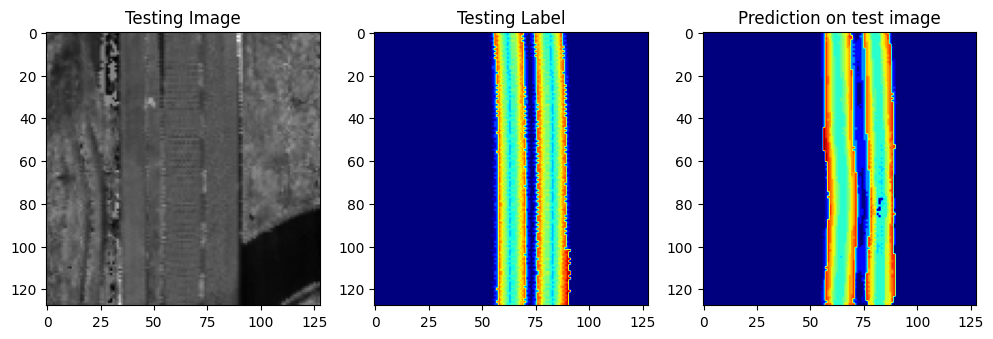

In [ ]:
import random
import matplotlib.pyplot as plt
test_img = X_test[0]
ground_truth=Y_test[0]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.savefig('results_10k_32_10_0015_predict_custom1.png', format='png')
plt.show()